Name - Syed Imam Ali<br>
Roll No. - AI24MTECH14005<br>
Name - Somya Suwas<br>
Roll No. - AI24MTECH14001

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import rankdata, norm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Use MPS if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [4]:
filepath = '/Users/syedimamali/Downloads/data.xlsx'
df = pd.read_excel(filepath)

In [5]:
# Basic information
print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

Dataset shape: (1199, 10)

Column names:
['cov1', 'cov2', 'cov3', 'cov4', 'cov5', 'cov6', 'cov7', 'sal_pur_rat', 'igst_itc_tot_itc_rat', 'lib_igst_itc_rat']


In [6]:
# Display first few rows
print(df.head())

       cov1      cov2      cov3      cov4      cov5      cov6      cov7  \
0  0.997797  0.999888  0.215934  0.196713  0.000000  0.955616  0.998810   
1  0.994004  0.979902 -0.337135 -0.248634  0.000000  0.640812  0.553918   
2  0.947603  0.455667  0.001743  0.128610 -0.004054 -0.162069  0.960601   
3  0.396577  0.919933  0.496451  0.576824 -0.340718  0.802363  0.673710   
4  0.999893  0.327615  0.700477  0.315601  0.000000  0.300785  0.979009   

   sal_pur_rat  igst_itc_tot_itc_rat  lib_igst_itc_rat  
0    -0.032581              1.761759         -0.054329  
1    -0.032026             -0.629311         -0.053516  
2    -0.030209              1.535697         -0.054215  
3    -0.032058              0.449160         -0.054126  
4    -0.032224              1.762049         -0.054330  


In [7]:
# Data types
print("\nData types:")
print(df.dtypes)


Data types:
cov1                    float64
cov2                    float64
cov3                    float64
cov4                    float64
cov5                    float64
cov6                    float64
cov7                    float64
sal_pur_rat             float64
igst_itc_tot_itc_rat    float64
lib_igst_itc_rat        float64
dtype: object


In [8]:
# Summary statistics
print("\nSummary statistics:")
print(df.describe().T)


Summary statistics:
                       count          mean       std       min       25%  \
cov1                  1199.0  9.568964e-01  0.135031 -0.312219  0.982505   
cov2                  1199.0  8.557698e-01  0.244927 -0.531958  0.840675   
cov3                  1199.0  2.142635e-01  0.408193 -0.818128 -0.095193   
cov4                  1199.0  1.473587e-01  0.388080 -0.839158 -0.143054   
cov5                  1199.0  3.632851e-02  0.177615 -0.719622  0.000000   
cov6                  1199.0  5.998090e-01  0.334306 -0.682734  0.382479   
cov7                  1199.0  5.277684e-01  0.385322 -0.859529  0.245701   
sal_pur_rat           1199.0 -1.251042e-11  1.000000 -0.035313 -0.032841   
igst_itc_tot_itc_rat  1199.0 -5.004165e-12  1.000000 -1.066436 -0.888464   
lib_igst_itc_rat      1199.0  1.918265e-11  1.000000 -0.054448 -0.054244   

                           50%       75%        max  
cov1                  0.999235  0.999993   1.000000  
cov2                  0.969806  0.

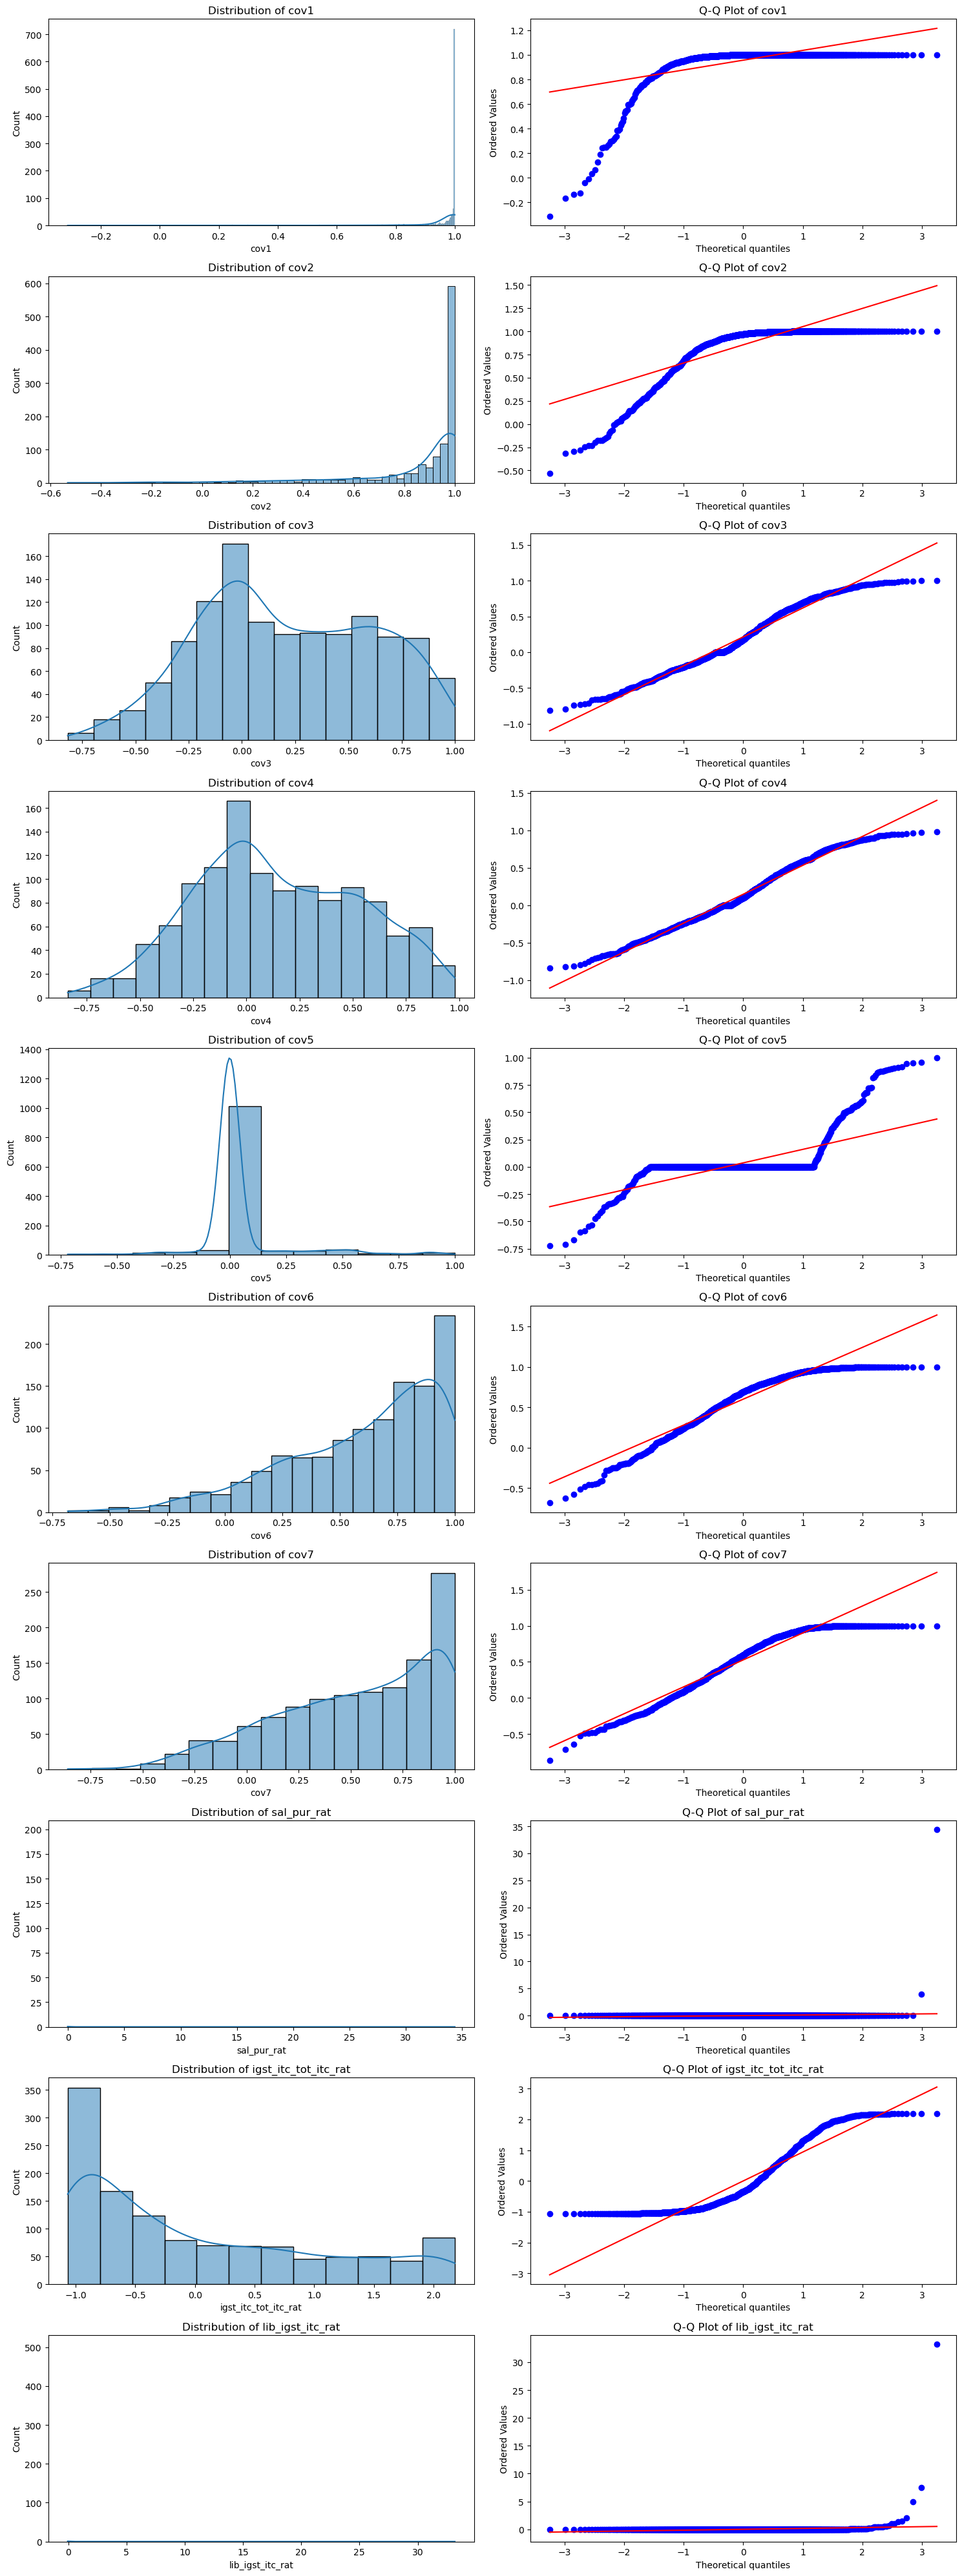

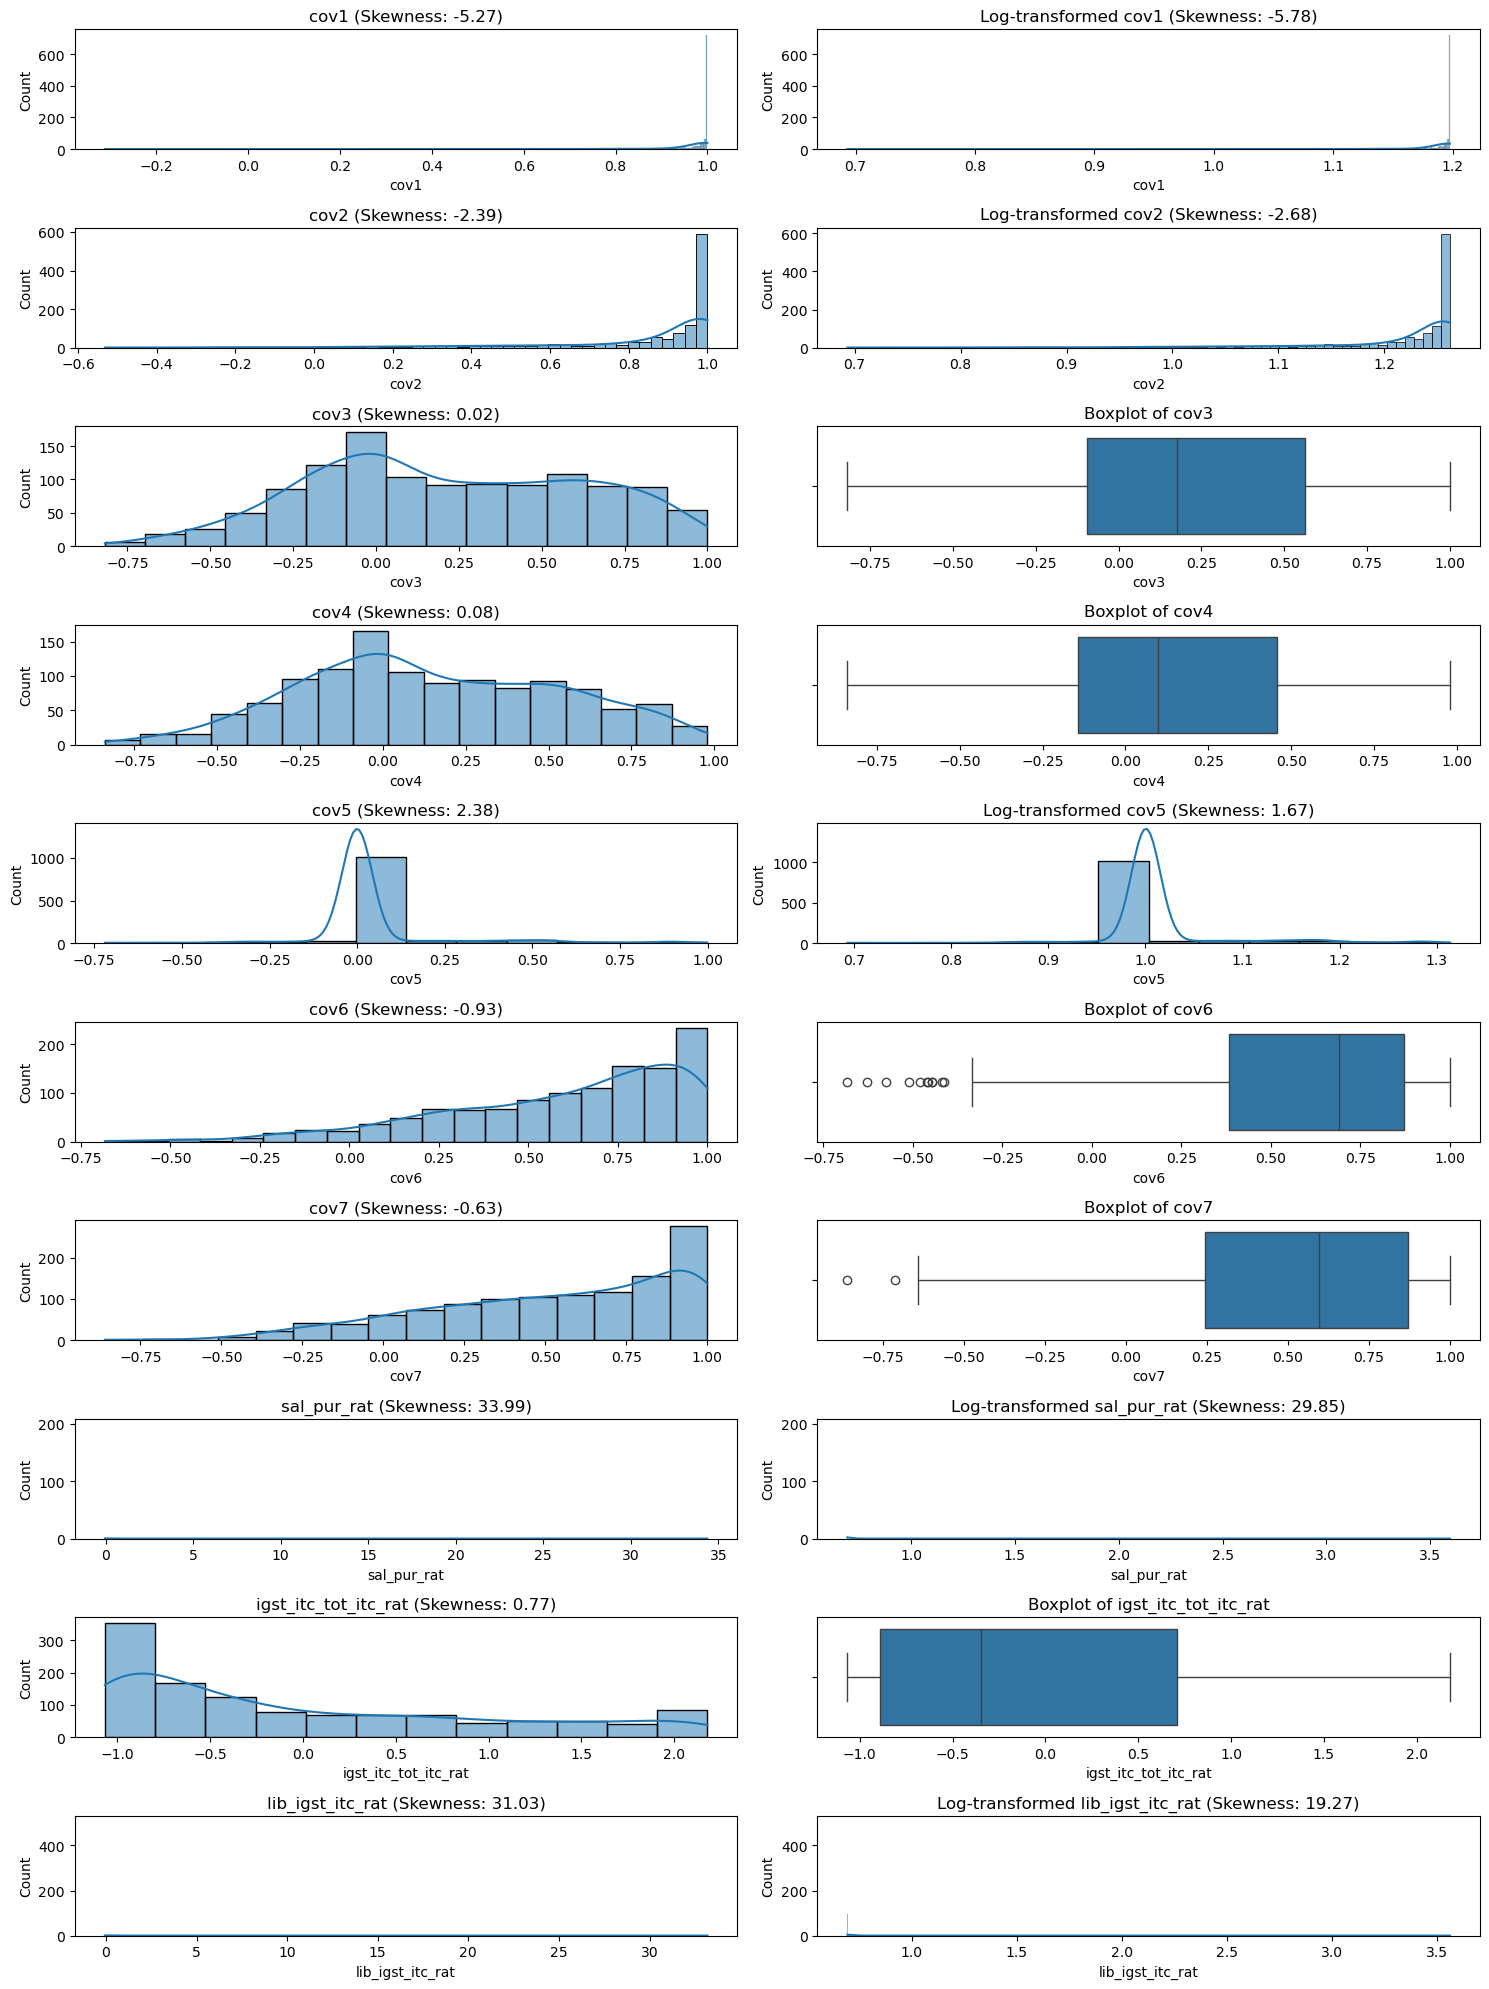

In [9]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Histogram and distribution plots
plt.figure(figsize=(15, len(numerical_cols)*4))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 2, 2*i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')

    plt.subplot(len(numerical_cols), 2, 2*i+2)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {col}')

plt.tight_layout()
plt.show()

# Log-transformed distributions for skewed data
plt.figure(figsize=(15, len(numerical_cols)*2))
for i, col in enumerate(numerical_cols):
    # Calculate skewness
    skewness = df[col].skew()

    plt.subplot(len(numerical_cols), 2, 2*i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} (Skewness: {skewness:.2f})')

    # If highly skewed, show log-transformed version
    if abs(skewness) > 1:
        if df[col].min() <= 0:
            transformed = np.log1p(df[col] - df[col].min() + 1)
        else:
            transformed = np.log(df[col])

        plt.subplot(len(numerical_cols), 2, 2*i+2)
        sns.histplot(transformed, kde=True)
        plt.title(f'Log-transformed {col} (Skewness: {transformed.skew():.2f})')
    else:
        plt.subplot(len(numerical_cols), 2, 2*i+2)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


Model

In [12]:
real_cols = df.columns.tolist()
data_raw = df.values

In [13]:
# === Gaussian Copula ===
def copula_transform(data):
    return np.array([
        rankdata(col, method='average') / (len(col) + 1)
        for col in data.T
    ]).T

def gaussian_copula_transform(data):
    u_data = copula_transform(data)
    return norm.ppf(u_data)

def inverse_copula_transform(u_data, original_data):
    sorted_vals = np.sort(original_data, axis=0)
    ranks = (norm.cdf(u_data) * len(sorted_vals)).astype(int)
    ranks = np.clip(ranks, 0, len(sorted_vals) - 1)
    return np.take_along_axis(sorted_vals, ranks, axis=0)


In [14]:
# === GAN Components ===
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, z):
        return self.model(z)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.model(x)


In [15]:
# === Gradient Penalty ===
def compute_gp(critic, real, fake):
    alpha = torch.rand(real.size(0), 1).to(device)
    alpha = alpha.expand_as(real)
    interpolated = alpha * real + (1 - alpha) * fake
    interpolated.requires_grad_(True)
    d_interpolated = critic(interpolated)
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [16]:
# === Prepare data ===
copula_data = gaussian_copula_transform(data_raw)
data_tensor = torch.tensor(copula_data, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(data_tensor), batch_size=64, shuffle=True)

In [ ]:
# === Model Setup ===
noise_dim = 100
G = Generator(noise_dim, copula_data.shape[1]).to(device)
D = Critic(copula_data.shape[1]).to(device)

g_opt = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
d_opt = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))

lambda_gp = 10
n_critic = 5
num_epochs = 5000

g_losses, d_losses = [], []

In [28]:
# === Training Loop ===
for epoch in range(num_epochs):
    for (real_batch,) in dataloader:
        real_batch = real_batch.to(device)
        bsz = real_batch.size(0)

        for _ in range(n_critic):
            z = torch.randn(bsz, noise_dim).to(device)
            fake_batch = G(z).detach()
            d_real = D(real_batch)
            d_fake = D(fake_batch)
            gp = compute_gp(D, real_batch, fake_batch)

            d_loss = -d_real.mean() + d_fake.mean() + lambda_gp * gp
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

        z = torch.randn(bsz, noise_dim).to(device)
        fake_data = G(z)
        g_loss = -D(fake_data).mean()
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 50 == 0 or epoch == num_epochs - 1:
        print(f"[Epoch {epoch}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

[Epoch 0] D Loss: 1.2031, G Loss: -0.1393
[Epoch 50] D Loss: -1.0574, G Loss: -0.8501
[Epoch 100] D Loss: 0.1214, G Loss: 0.4761
[Epoch 150] D Loss: 0.1056, G Loss: 0.8123
[Epoch 200] D Loss: -0.2585, G Loss: 0.4308
[Epoch 250] D Loss: -0.2954, G Loss: 0.6926
[Epoch 300] D Loss: -0.2101, G Loss: 0.5009
[Epoch 350] D Loss: -0.2668, G Loss: -2.2311
[Epoch 400] D Loss: 0.0901, G Loss: -1.2978
[Epoch 450] D Loss: -0.0872, G Loss: -0.2991
[Epoch 500] D Loss: 0.1496, G Loss: -1.6068
[Epoch 550] D Loss: 0.1263, G Loss: -1.3096
[Epoch 600] D Loss: -0.0163, G Loss: -0.9363
[Epoch 650] D Loss: -0.3096, G Loss: -0.8039
[Epoch 700] D Loss: -0.1680, G Loss: -0.6414
[Epoch 750] D Loss: -0.3637, G Loss: -0.4094
[Epoch 800] D Loss: -0.2047, G Loss: -0.4806
[Epoch 850] D Loss: -0.1431, G Loss: -0.5186
[Epoch 900] D Loss: -0.2773, G Loss: -1.0425
[Epoch 950] D Loss: -0.1019, G Loss: -1.8424
[Epoch 1000] D Loss: -0.1788, G Loss: -1.9014
[Epoch 1050] D Loss: -0.2013, G Loss: -1.9301
[Epoch 1100] D Loss: -

In [19]:
# === Training Loop ===
for epoch in range(num_epochs):
    for (real_batch,) in dataloader:
        real_batch = real_batch.to(device)
        bsz = real_batch.size(0)

        for _ in range(n_critic):
            z = torch.randn(bsz, noise_dim).to(device)
            fake_batch = G(z).detach()
            d_real = D(real_batch)
            d_fake = D(fake_batch)
            gp = compute_gp(D, real_batch, fake_batch)

            d_loss = -d_real.mean() + d_fake.mean() + lambda_gp * gp
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

        z = torch.randn(bsz, noise_dim).to(device)
        fake_data = G(z)
        g_loss = -D(fake_data).mean()
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    if epoch % 50 == 0 or epoch == num_epochs - 1:
        print(f"[Epoch {epoch}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

[Epoch 0] D Loss: 0.9991, G Loss: -0.2973
[Epoch 50] D Loss: -0.8055, G Loss: -1.2079
[Epoch 100] D Loss: -0.2529, G Loss: 0.3765
[Epoch 150] D Loss: -0.2686, G Loss: 1.0895
[Epoch 200] D Loss: -0.3190, G Loss: 1.2442
[Epoch 250] D Loss: -0.3772, G Loss: 1.5859
[Epoch 300] D Loss: -0.4201, G Loss: 1.7738
[Epoch 350] D Loss: -0.3969, G Loss: 1.6434
[Epoch 400] D Loss: -0.4678, G Loss: 1.2624
[Epoch 450] D Loss: -0.3294, G Loss: 1.1226
[Epoch 499] D Loss: -0.2423, G Loss: -1.7572


In [22]:
# === Generate Samples ===
G.eval()
with torch.no_grad():
    z = torch.randn(1000, noise_dim).to(device)
    synthetic_copula = G(z).cpu().numpy()
    synthetic_final = inverse_copula_transform(synthetic_copula, data_raw)
    synthetic_df = pd.DataFrame(synthetic_final, columns=real_cols)

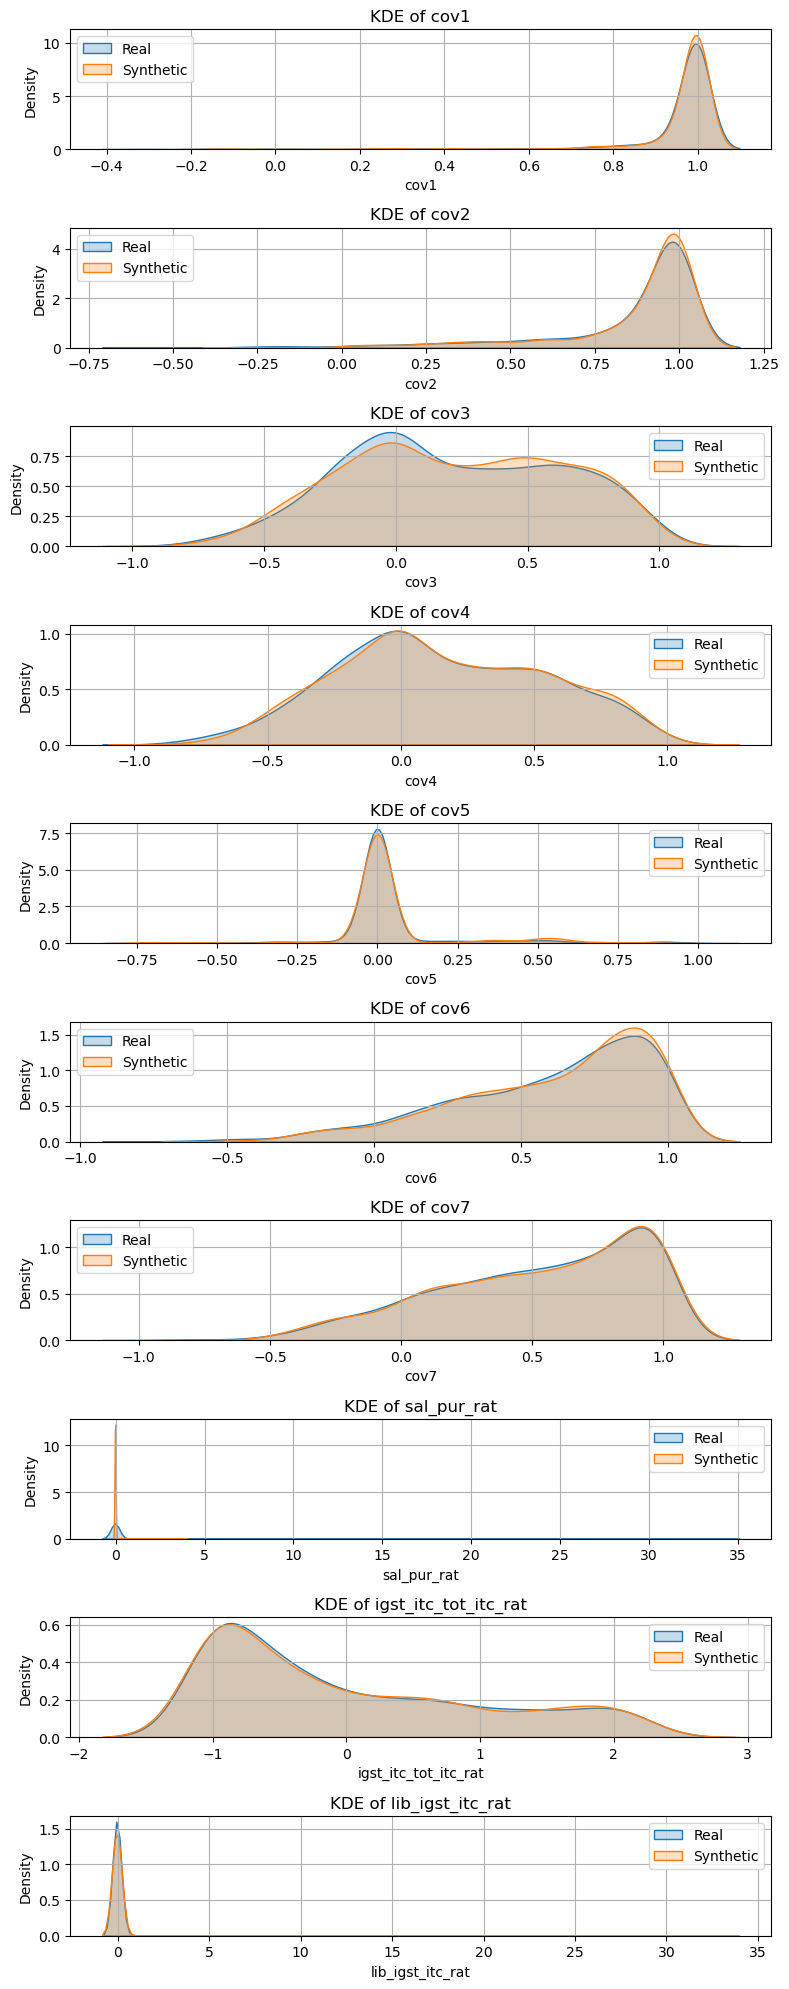

In [31]:
# === KDE Plot ===
fig, axes = plt.subplots(len(real_cols), 1, figsize=(8, len(real_cols)*2))
for i, col in enumerate(real_cols):
    sns.kdeplot(df[col], ax=axes[i], label='Real', fill=True)
    sns.kdeplot(synthetic_df[col], ax=axes[i], label='Synthetic', fill=True)
    axes[i].set_title(f"KDE of {col}")
    axes[i].legend()
    axes[i].grid(True)
plt.tight_layout()
plt.show()

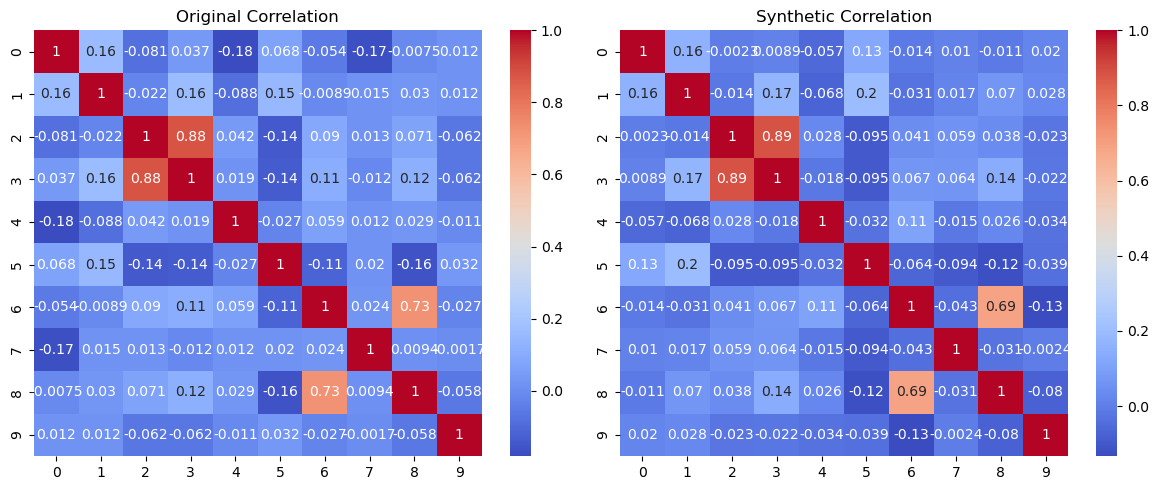

In [23]:
# === Correlation Heatmap Comparison ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(np.corrcoef(data_raw.T), cmap='coolwarm', annot =True)
plt.title('Original Correlation')

plt.subplot(1, 2, 2)
sns.heatmap(np.corrcoef(synthetic_df.values.T), cmap='coolwarm', annot = True)
plt.title('Synthetic Correlation')
plt.tight_layout()
plt.show()